In [46]:
%matplotlib inline
import os
import inspect
import logging
from mysql import connector
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model

class AQ:

    # Global constants
    WS_PATH = os.path.abspath("./") + os.sep
    DB_HOST = "127.0.0.1"
    DB_USR = "root"
    DB_PWD = "!QAZ2wsx#EDC"
    DB_NAME = "aq"
    
    def log(self, msg):
        print(msg)
        
class LR:
    def __init__(self, aq):
        self.aq = aq
        
    def get_data(self, code, type):
        mysql_connector = connector.connect(host=self.aq.DB_HOST, database=self.aq.DB_NAME,
                                            user=self.aq.DB_USR, password=self.aq.DB_PWD)
        data = pd.read_sql("""SELECT close, high-low as hl, close-open as oc FROM future_trade WHERE code='%s' AND type='%s' """ % (code, type), 
                              con=mysql_connector)
        data_1 = data.close.diff()
        data_1[0] = 0
        data_2 = data.hl
        data_3 = data.oc
        data = pd.DataFrame({"data_1":data_1, "data_2":data_2, "data_3":data_3})
        #data = pd.DataFrame(preprocessing.normalize(data), columns=["data_1", "data_2", "data_3"])
        mysql_connector.close()
        return data
    
    def get_Y(self, data, lag_1, lag_2, lag_3):
        Y = data.data_1[max(lag_1, lag_2, lag_3):]
        Y.index = range(len(Y))
        return Y

    def get_X(self, data, lag_1, lag_2, lag_3):
        X = pd.DataFrame(columns=range(lag_1 + lag_2 + lag_3))
        for idx, row in data.iterrows():
            if idx >= lag_1 and idx >= lag_2 and idx >= lag_3:
                data_1 = data.iloc[(idx - lag_1):idx, 0]
                data_2 = data.iloc[(idx - lag_2):idx, 1]
                data_3 = data.iloc[(idx - lag_3):idx, 2]
                xrow = pd.concat([data_1, data_2, data_3], ignore_index=True)
                X = X.append(xrow, ignore_index=True)
        return X
    
    def cross_check(self, model, k_fold, X, Y):
        hit_rate_sum = 0
        stride = round(len(Y) / k_fold)
        for i in range(0, k_fold):
            start = i * stride
            stop = i * stride + stride - 1
            if (i == k_fold - 1):
                stop = len(Y)            
            X_test = X[start:stop]
            Y_test = Y[start:stop]
            if (i == 0):
                X_train = X[stop:]
                Y_train = Y[stop:]
            else:
                X_train = pd.concat([X[0:start], X[stop:]])
                Y_train = pd.concat([Y[0:start], Y[stop:]])            
            model.fit(X_train, Y_train)
            
            # The coefficients
            #self.aq.log("Coefficients: %s \n" % model.coef_)
            # The mean squared error
            self.aq.log("Mean squared error: %.2f" % (np.mean((model.predict(X_test) - Y_test) ** 2)))
            # Explained variance score: 1 is perfect prediction
            self.aq.log("Variance score: %.2f" % model.score(X_test, Y_test))
            self.aq.log("\n")
            
            plt.scatter(Y_test, model.predict(X_test), color='blue', linewidth=3)
            plt.show()

    def execute(self, code, type, lag, k_fold):
        self.aq.log("Code=%s, Type=%s, lag=%s, k_fold=%s" % (code,type,lag,k_fold))
        mysql_connector = connector.connect(host=self.aq.DB_HOST, database=self.aq.DB_NAME,
                                            user=self.aq.DB_USR, password=self.aq.DB_PWD)
        
        data = self.get_data(code, type)

        lag_1 = lag
        lag_2 = lag
        lag_3 = lag
        
        X = self.get_X(data, lag_1, lag_2, lag_3)
        Y = self.get_Y(data, lag_1, lag_2, lag_3)
        
        model = linear_model.LinearRegression()
        self.cross_check(model, k_fold, X, Y)        
        
        mysql_connector.close()

Code=I, Type=d, lag=5, k_fold=10
Mean squared error: 106.21
Variance score: -0.01




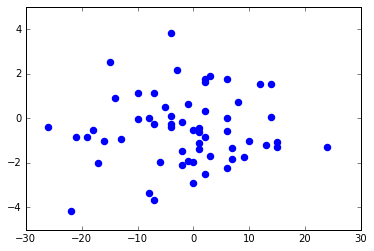

Mean squared error: 119.92
Variance score: -0.11




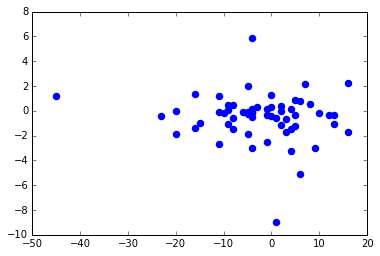

Mean squared error: 60.93
Variance score: -0.00




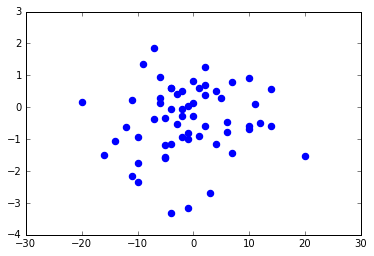

Mean squared error: 63.66
Variance score: -0.01




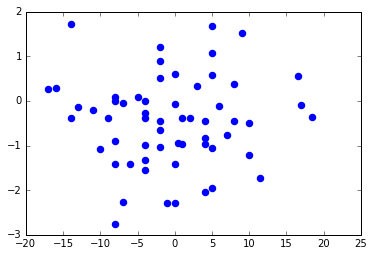

Mean squared error: 84.75
Variance score: -0.03




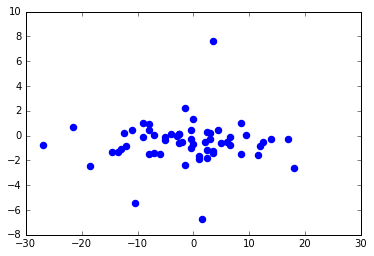

Mean squared error: 42.99
Variance score: -0.01




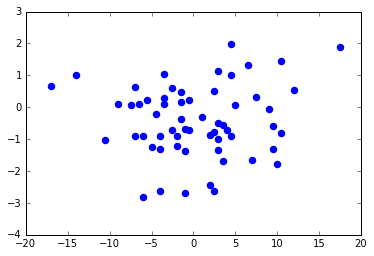

Mean squared error: 41.50
Variance score: -0.02




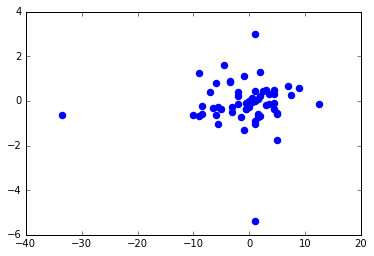

Mean squared error: 95.15
Variance score: -0.16




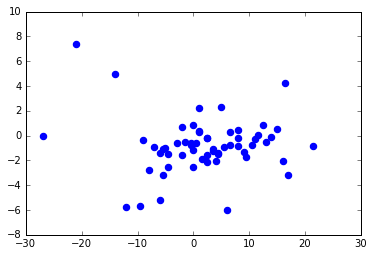

Mean squared error: 130.68
Variance score: 0.02




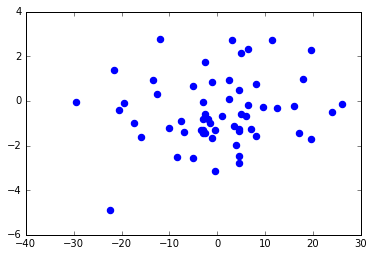

Mean squared error: 176.87
Variance score: -0.09




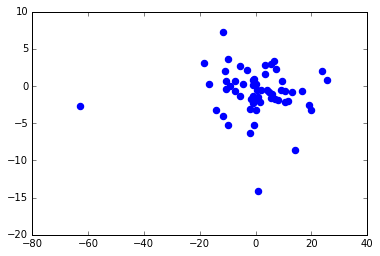

In [47]:
lr = LR(AQ())
code = "I"
type = "d"
lr.execute(code, type, 5, 10)